# Comprehensive GRN Inference and Data Processing Pipeline
This notebook provides an end-to-end pipeline for processing single-cell data to infer and format Gene Regulatory Networks (GRNs). It integrates several steps from initial inference with CellOracle to final data generation and visualization for downstream machine learning tasks. All outputs from this notebook will be saved into organized subdirectories under a single main result folder.

## Block 1: Unified Imports, Paths, and Parameters

* All required libraries are imported here. All output paths are now consolidated into specific subdirectories under BASE_OUTPUT_DIR. All other file paths and key parameters are defined in this central location for easy configuration.
* The required h5ad-related data files can be obtained through the **data_preparation.ipynb** file. Download links for celloracle-related files:<https://github.com/morris-lab/CellOracle>.

In [ ]:
# --- Unified Imports ---
import os
import re
import sys
import pickle
from collections import defaultdict
import warnings

import anndata as ad
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scanpy as sc
import celloracle as co
import os
import re
import pandas as pd
from tqdm.auto import tqdm


%matplotlib inline

# Suppress minor warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
print("✅ All libraries imported successfully.")

# --- Unified Path and Parameter Management ---

# --- Main Input Directory ---
BASE_INPUT_PATH = ".data/kidney/"

# --- << MODIFIED >> Main Output Directory ---
BASE_OUTPUT_DIR = "./result/kidney/"

# --- Source Data Paths (Inputs) ---
ADATA_INPUT_DIR = os.path.join(BASE_INPUT_PATH, "time")
GO_FOLDER = os.path.join(BASE_INPUT_PATH, "GO_genes/")
BASE_GRN_FILE = "./data/celloracle/data/promoter_base_GRN/hg38_TFinfo_dataframe_gimmemotifsv5_fpr2_threshold_10_20210630.parquet"
GENE_MAP_FILE = os.path.join(BASE_INPUT_PATH, "gene_mapping_final.csv")
FULL_ADATA_FILE = os.path.join(BASE_INPUT_PATH, "kidney1_final_annotated.h5ad")

# --- << NEW >> Organized Output Subdirectories ---
ORACLE_DIR = os.path.join(BASE_OUTPUT_DIR, "1_oracle_links")
RAW_GRN_CSV_DIR = os.path.join(BASE_OUTPUT_DIR, "2_raw_grn_csv")
PROCESSED_GRN_CSV_DIR = os.path.join(BASE_OUTPUT_DIR, "3_processed_grn_csv")
ML_DATA_DIR = os.path.join(BASE_OUTPUT_DIR, "4_ml_ready_data")
FIGURE_SAVE_PATH = os.path.join(BASE_OUTPUT_DIR, "5_figures")

# --- Parameters ---
EXAMPLE_TIMEPOINT = "66"
CELL_TYPES_TO_PROCESS = ['PT-S1-A', 'PT-S1-B', 'PT-S1-C', 'PT-S1-D', 'PT-S2-A', 'PT-S2-B', 'PT-S2-C', 'aPT-A', 'aPT-B'] # Reduced list for faster demo

# Create all necessary directories
for path in [ORACLE_DIR, RAW_GRN_CSV_DIR, PROCESSED_GRN_CSV_DIR, ML_DATA_DIR, FIGURE_SAVE_PATH]:
    os.makedirs(path, exist_ok=True)

print(f"✅ Paths configured. All outputs will be saved in organized subdirectories under: ./DynPertub/data_code/GRN/result")

✅ All libraries imported successfully.
✅ Paths configured. All outputs will be saved in organized subdirectories under: ./DynPertub/data_code/GRN/result


## Block 2:  Initial GRN Inference with CellOracle (Demonstration)

This section runs the CellOracle pipeline for a single example timepoint.

In [9]:
print("--- Starting Section 2: Initial GRN Inference with CellOracle (Demonstration) ---")

# Define the full path for the input AnnData file
adata_file = os.path.join(ADATA_INPUT_DIR, f"{EXAMPLE_TIMEPOINT}-year-old_stage.h5ad")

# Check if the necessary input file exists before starting
if os.path.exists(adata_file):

    print("Loading and preprocessing data...")

    # 1. Load and preprocess the data
    adata = sc.read_h5ad(adata_file)
    sc.pp.filter_genes(adata, min_counts=1)

    filter_result = sc.pp.filter_genes_dispersion(adata.X, flavor='cell_ranger', n_top_genes=3000, log=False)
    adata = adata[:, filter_result.gene_subset]
    sc.pp.normalize_total(adata, target_sum=1e4)
    adata.raw = adata
    adata.layers["raw_count"] = adata.raw.X.copy()

    # Subsample if the dataset is too large, to speed up the process
    n_cells_downsample = 30000
    if adata.shape[0] > n_cells_downsample:
        print(f"Subsampling data from {adata.shape[0]} to {n_cells_downsample} cells.")
        sc.pp.subsample(adata, n_obs=n_cells_downsample, random_state=123)

    # 2. Initialize CellOracle and load base GRN
    print("Initializing CellOracle and loading base GRN for TFs...")
    base_GRN = pd.read_parquet(BASE_GRN_FILE)
    oracle = co.Oracle()
    oracle.import_anndata_as_normalized_count(adata=adata, cluster_column_name="final_type", embedding_name="X_pca")
    oracle.import_TF_data(TF_info_matrix=base_GRN)

    # 3. Perform PCA and KNN imputation
    print("Performing PCA to determine optimal components...")
    oracle.perform_PCA()
    n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
    n_comps = min(n_comps, 50)
    print(f"Optimal number of PCA components: {n_comps}")

    print("Performing KNN imputation (this may take a few minutes)...")
    n_cell = oracle.adata.shape[0]
    k = int(0.025 * n_cell)
    oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=4)

    # 4. Calculate GRN links - THIS IS THE MAIN COMPUTATION STEP
    print("Calculating GRN links (this is the most time-consuming step)...")
    links = oracle.get_links(cluster_name_for_GRN_unit="final_type", alpha=10, verbose_level=10)

    # 5. Save the final, valid .links file
    print("Saving results to HDF5 file...")
    links_output_path = os.path.join(ORACLE_DIR, f"{EXAMPLE_TIMEPOINT}.celloracle.links")
    links.to_hdf5(links_output_path) # This is the correct save function

    print(f"✅ Section 2 finished successfully. The Oracle .links file has been saved to the 1_oracle_links folder.")

else:
    print(f"⚠️ Error: Input data file not found at the specified path: {adata_file}")
    print("Please ensure the input data is in the correct location before running this cell.")

--- Starting Section 2: Initial GRN Inference with CellOracle (Demonstration) ---
Loading and preprocessing data...
Initializing CellOracle and loading base GRN for TFs...
Performing PCA to determine optimal components...
Optimal number of PCA components: 50
Performing KNN imputation (this may take a few minutes)...
Calculating GRN links (this is the most time-consuming step)...


  0%|          | 0/9 [00:00<?, ?it/s]

Inferring GRN for PT-S1-A...


  0%|          | 0/2741 [00:00<?, ?it/s]

Inferring GRN for PT-S1-B...


  0%|          | 0/2741 [00:00<?, ?it/s]

Inferring GRN for PT-S1-C...


  0%|          | 0/2741 [00:00<?, ?it/s]

Inferring GRN for PT-S1-D...


  0%|          | 0/2741 [00:00<?, ?it/s]

Inferring GRN for PT-S2-A...


  0%|          | 0/2741 [00:00<?, ?it/s]

Inferring GRN for PT-S2-B...


  0%|          | 0/2741 [00:00<?, ?it/s]

Inferring GRN for PT-S2-C...


  0%|          | 0/2741 [00:00<?, ?it/s]

Inferring GRN for aPT-A...


  0%|          | 0/2741 [00:00<?, ?it/s]

Inferring GRN for aPT-B...


  0%|          | 0/2741 [00:00<?, ?it/s]

Saving results to HDF5 file...
✅ Section 2 finished successfully. The Oracle .links file has been saved to the 1_oracle_links folder.


## Block 3: Converting CellOracle Links to CSV

This block iterates through the `.links` files (generated from running the above step for all timepoints) and converts them into a more manageable CSV format for each cell type.

In [2]:

print("--- Starting Section 3 (Full Processing Mode): Converting .links to CSV ---")

# Lists to keep track of the processing results
successfully_created_files = []
skipped_cell_types = []

# 1. Iterate through all the target cell types defined in the setup cell
for cell_type in CELL_TYPES_TO_PROCESS:
    print(f"\n[*] Processing target cell type: '{cell_type}'")

    output_file_path = os.path.join(RAW_GRN_CSV_DIR, f"{cell_type}.csv")
    # To prevent appending data on re-runs, delete the old file if it exists before processing a new cell type
    if os.path.exists(output_file_path):
        os.remove(output_file_path)

    # 2. Find all .links input files
    # Sort the files numerically by timepoint to ensure sequential processing
    file_list = sorted([f for f in os.listdir(ORACLE_DIR) if f.endswith(".celloracle.links")],
                       key=lambda f: int(re.match(r'(\d+)', f).group(1)) if re.match(r'(\d+)', f) else 0)

    if not file_list:
        print("   [ERROR] No .celloracle.links files found in the input directory!")
        break

    found_data_for_cell_type = False
    for file_name in file_list:
        file_path = os.path.join(ORACLE_DIR, file_name)
        timepoint = re.match(r"(\d+)", file_name).group(1)

        links = co.load_hdf5(file_path=file_path)

        # 3. Key check: Does the cell type exist as a key in the loaded links object?
        if cell_type in links.links_dict:
            df = links.links_dict[cell_type].copy()

            # 4. Filter the data (p < 0.001 and take the top 10,000 links by absolute coefficient)
            df_filtered = df[(df["p"].notna()) & (df["p"] < 0.001)].copy()
            df_filtered = df_filtered.sort_values("coef_abs", ascending=False).head(10000)

            if not df_filtered.empty:
                df_filtered.insert(0, "Timepoints", timepoint)

                # 5. Write to the file (using append mode 'a')
                is_new_file = not os.path.exists(output_file_path)
                df_filtered.to_csv(output_file_path, mode="a", index=False, header=is_new_file)
                found_data_for_cell_type = True

    # 6. Update the report lists based on whether any data was found and saved
    if found_data_for_cell_type:
        print(f"   ✅ Data found and CSV file created/updated for '{cell_type}'.")
        successfully_created_files.append(os.path.basename(output_file_path))
    else:
        print(f"   ⚠️ No data found for '{cell_type}' across all .links files. This CSV was not created.")
        skipped_cell_types.append(cell_type)

# --- Final Summary Report ---
print("\n======================= SUMMARY REPORT =======================")
print(f"✅ Section 3 finished processing {len(CELL_TYPES_TO_PROCESS)} target cell types.")
print(f"\nSuccessfully created {len(successfully_created_files)} CSV file(s):")
for f in successfully_created_files:
    print(f"  - {f}")

if skipped_cell_types:
    print(f"\nSkipped {len(skipped_cell_types)} cell type(s) due to no matching data found:")
    for ct in skipped_cell_types:
        print(f"  - {ct}")
print("============================================================")

# --- Display a sample from the first successful file ---
if successfully_created_files:
    sample_file_path = os.path.join(RAW_GRN_CSV_DIR, successfully_created_files[0])
    print(f"\nDisplaying a sample from the first successful file '{successfully_created_files[0]}':")
    df_sample = pd.read_csv(sample_file_path)
    display(df_sample.head())
else:
    print("\nNo CSV files were created, so no sample can be displayed.")

--- Starting Section 3 (Full Processing Mode): Converting .links to CSV ---

[*] Processing target cell type: 'PT-S1-A'
   ✅ Data found and CSV file created/updated for 'PT-S1-A'.

[*] Processing target cell type: 'PT-S1-B'
   ✅ Data found and CSV file created/updated for 'PT-S1-B'.

[*] Processing target cell type: 'PT-S1-C'
   ✅ Data found and CSV file created/updated for 'PT-S1-C'.

[*] Processing target cell type: 'PT-S1-D'
   ⚠️ No data found for 'PT-S1-D' across all .links files. This CSV was not created.

[*] Processing target cell type: 'PT-S2-A'
   ✅ Data found and CSV file created/updated for 'PT-S2-A'.

[*] Processing target cell type: 'PT-S2-B'
   ✅ Data found and CSV file created/updated for 'PT-S2-B'.

[*] Processing target cell type: 'PT-S2-C'
   ✅ Data found and CSV file created/updated for 'PT-S2-C'.

[*] Processing target cell type: 'aPT-A'
   ✅ Data found and CSV file created/updated for 'aPT-A'.

[*] Processing target cell type: 'aPT-B'
   ✅ Data found and CSV file 

,Timepoints,source,target,coef_mean,coef_abs,p,-logp
0,66,HNF4A,MT1G,-4.325339,4.325339,1.684128e-10,9.773625
1,66,HNF4A,MT2A,-2.737235,2.737235,2.644860e-13,12.577597
2,66,MAX,MT1G,2.522228,2.522228,6.691176e-09,8.174498
3,66,ARID3B,SLC5A2,2.503493,2.503493,1.106868e-11,10.955904
4,66,MECP2,SLC34A1,2.496783,2.496783,1.861595e-12,11.730115


## Block 4: Preprocessing Raw GRN CSVs

This step cleans the raw CSV files by mapping gene names to IDs, standardizing the timepoint column, and saving the result as a new `processed_*.csv` file.

In [5]:
print("--- Starting Section 4: Preprocessing Raw CSVs ---")

gene_mapping_df = pd.read_csv(GENE_MAP_FILE)
gene_dict = dict(zip(gene_mapping_df['Gene'], gene_mapping_df['ID']))

for file_name in os.listdir(RAW_GRN_CSV_DIR):
    if not file_name.endswith('.csv') or file_name.startswith('processed_'):
        continue
    
    input_path = os.path.join(RAW_GRN_CSV_DIR, file_name)
    output_path = os.path.join(PROCESSED_GRN_CSV_DIR, f'processed_{file_name}')
    
    print(f"Processing: {file_name}")
    df = pd.read_csv(input_path)
    if df.empty:
        print(f"⚠️ Skipping empty file: {file_name}")
        continue
    
    df.columns = ['Timepoints', 'source', 'target', 'coef_mean', 'coef_abs', 'p', '-logp']
    df['source'] = df['source'].map(gene_dict)
    df['target'] = df['target'].map(gene_dict)
    df.dropna(subset=['source', 'target'], inplace=True)
    
    df['Timepoints'] = df['Timepoints'].astype(str).str.extract(r'(\d+)').iloc[:, 0]
    df.dropna(subset=['Timepoints'], inplace=True)
    df['Timepoints'] = df['Timepoints'].astype(int)
    
    df = df[['source', 'target', 'coef_mean', 'coef_abs', 'p', '-logp', 'Timepoints']]
    df.sort_values(by='Timepoints', inplace=True)
    df.to_csv(output_path, index=False)

print("✅ Section 4 finished.")

--- Starting Section 4: Preprocessing Raw CSVs ---
Processing: PT-S1-A.csv
Processing: PT-S1-C.csv
Processing: aPT-B.csv
Processing: PT-S2-B.csv
Processing: PT-S1-B.csv
Processing: aPT-A.csv
Processing: PT-S2-A.csv
Processing: PT-S2-C.csv
✅ Section 4 finished.


## Block 5: Generating Node Features from Gene Expression

Here, we process the full AnnData object to extract gene expression values for each cell type at each timepoint, creating node feature files (`*_node.pkl`) for the graph models.

In [7]:
from tqdm.auto import tqdm

print("--- Starting Section 5 (Filtered for Timepoint 66): Generating Node Features ---")

# Step 1: Data Loading and Preparation
print("\nStep 1/3: Loading and preparing the main AnnData file...")
adata = ad.read_h5ad(FULL_ADATA_FILE)
gene_mapping_df = pd.read_csv(GENE_MAP_FILE)
gene_id_map = dict(zip(gene_mapping_df['Gene'], gene_mapping_df['ID']))
adata.var_names = [str(gene_id_map.get(gene, gene)) for gene in adata.var_names]

obs_df = adata.obs.copy()
obs_df['time'] = obs_df['time'].astype(str).str.extract(r'(\d+)').iloc[:, 0]
obs_df.dropna(subset=['time'], inplace=True)
obs_df['time'] = obs_df['time'].astype(int)
print("   ... Data loaded and prepared successfully.")

# Step 2: Filter for the specific timepoint
TARGET_TIMEPOINT = 66
print(f"\nStep 2/3: Filtering data to ONLY include timepoint {TARGET_TIMEPOINT}...")
obs_df = obs_df[obs_df['time'] == TARGET_TIMEPOINT].copy()
if obs_df.empty:
    print(f"   ⚠️ Warning: No data found for timepoint {TARGET_TIMEPOINT}. The script will not process any groups.")
else:
    print(f"   ... Found {len(obs_df)} cells for timepoint {TARGET_TIMEPOINT}.")

# Step 3: Processing the filtered groups
print(f"\nStep 3/3: Processing each cell group for timepoint {TARGET_TIMEPOINT}...")
grouped = obs_df.groupby(['final_type', 'time'])
all_celltype_expr = defaultdict(lambda: defaultdict(dict))

for (cell_type, timepoint), group in tqdm(grouped, desc="Processing cell groups"):
    cell_indices = group.index.tolist()
    if not cell_indices: continue

    group_adata = adata[cell_indices, :]
    cell_expr_data = pd.DataFrame(
        group_adata.X.toarray() if hasattr(group_adata.X, "toarray") else group_adata.X,
        columns=group_adata.var_names
    )

    for gene_id in cell_expr_data.columns:
        non_nan_values = cell_expr_data[gene_id].dropna().values
        if len(non_nan_values) >= 1000:
            selected = np.random.choice(non_nan_values, 1000, replace=False).tolist()
        elif len(non_nan_values) > 0:
            selected = np.random.choice(non_nan_values, 1000, replace=True).tolist()
        else:
            selected = [0.0] * 1000
        all_celltype_expr[cell_type][str(gene_id)][timepoint] = selected

# Step 4: Saving the output
print("\nStep 4/4: Saving node feature files...")
for cell_type, gene_expr_data in all_celltype_expr.items():
    save_name = cell_type.replace('/', '_')
    out_path = os.path.join(ML_DATA_DIR, f'ml_{save_name}_node.pkl')
    with open(out_path, 'wb') as f:
        pickle.dump(dict(gene_expr_data), f)


print("\n✅ Section 5 finished.")

--- Starting Section 5 (Filtered for Timepoint 66): Generating Node Features ---

Step 1/3: Loading and preparing the main AnnData file...
   ... Data loaded and prepared successfully.

Step 2/3: Filtering data to ONLY include timepoint 66...
   ... Found 111 cells for timepoint 66.

Step 3/3: Processing each cell group for timepoint 66...


Processing cell groups:   0%|          | 0/9 [00:00<?, ?it/s]


Step 4/4: Saving node feature files...

✅ Section 5 finished.


## Block 6: Final Data and Feature Generation for ML Models

This is the final processing step. It takes the `processed_*.csv` files, applies multi-label encoding based on Gene Ontology terms, and generates standardized feature arrays (`.npy`) and final dataframes (`ml_*.csv`) ready for machine learning.

In [7]:
print("--- Starting Section 6: Generating Final ML-ready Data ---")

target_go_terms = [
    "GO:0005515", "GO:0016020", "GO:0005737", "GO:0005634", "GO:0005886",
    "GO:0005829", "GO:0005654", "GO:0005576", "GO:0046872", "GO:0003677"
]
gene_mapping_df = pd.read_csv(GENE_MAP_FILE)
gene_name_to_id = dict(zip(gene_mapping_df["Gene"], gene_mapping_df["ID"]))
gene_to_gos = {}

for go_id in target_go_terms:
    file_path = os.path.join(GO_FOLDER, f"{go_id.replace(':', '')}.txt")
    if os.path.isfile(file_path):
        with open(file_path, 'r') as f:
            gene_names = [line.strip() for line in f if line.strip()]
            for gene_name in gene_names:
                gene_id = gene_name_to_id.get(gene_name)
                if gene_id is not None:
                    gene_to_gos.setdefault(str(int(gene_id)), set()).add(go_id)

def encode_multilabel(gene):
    gos = gene_to_gos.get(str(int(gene)), set())
    return [int(go in gos) for go in target_go_terms]

for file_name in os.listdir(PROCESSED_GRN_CSV_DIR):
    if not file_name.startswith("processed_"): continue

    base_name = file_name.replace("processed_", "").replace(".csv", "")
    print(f"\nGenerating final files for: {base_name}")

    df = pd.read_csv(os.path.join(PROCESSED_GRN_CSV_DIR, file_name))
    df = df[df["p"] < 0.001].copy()
    if df.empty:
        print(f"⚠️ No significant data for {base_name}. Skipping.")
        continue
    
    df["idx"] = range(1, len(df) + 1)
    df["label"] = df["source"].apply(encode_multilabel)
    
    df_out = df.rename(columns={"source": "u", "target": "i", "Timepoints": "ts"})
    df_out = df_out[["u", "i", "ts", "label", "idx"]]
    df_out.to_csv(os.path.join(ML_DATA_DIR, f"ml_{base_name}.csv"), index=False)
    
    feat_cols = ["coef_mean", "coef_abs", "p", "-logp"]
    feat_array = df[feat_cols].values
    feat_mean = np.nanmean(feat_array, axis=0)
    feat_std = np.nanstd(feat_array, axis=0)
    feat_std[feat_std == 0] = 1 # Avoid division by zero
    feat_array = (feat_array - feat_mean) / feat_std
    feat_array[np.isnan(feat_array)] = 0 # Impute NaNs after standardization
    np.save(os.path.join(ML_DATA_DIR, f"ml_{base_name}.npy"), feat_array)
    
    print(f"✅ Final data and features for {base_name} saved.")

print("✅ Section 6 finished.")

--- Starting Section 6: Generating Final ML-ready Data ---

Generating final files for: PT-S2-A
✅ Final data and features for PT-S2-A saved.

Generating final files for: PT-S2-C
✅ Final data and features for PT-S2-C saved.

Generating final files for: PT-S1-B
✅ Final data and features for PT-S1-B saved.

Generating final files for: aPT-A
✅ Final data and features for aPT-A saved.

Generating final files for: PT-S2-B
✅ Final data and features for PT-S2-B saved.

Generating final files for: PT-S1-A
✅ Final data and features for PT-S1-A saved.

Generating final files for: PT-S1-C
✅ Final data and features for PT-S1-C saved.

Generating final files for: aPT-B
✅ Final data and features for aPT-B saved.
✅ Section 6 finished.


## Block 7: Result Visualization

The final block loads one of the processed datasets and creates a network graph of the top interactions at the earliest timepoint. This serves as a visual confirmation that the pipeline has run successfully.

--- Starting Section 7 (Multi-Plot Mode): Visualizing All Results ---
Found 8 processed cell types to visualize.

--- Generating plot for: PT-S2-A ---
   ✅ Network visualization has been saved.


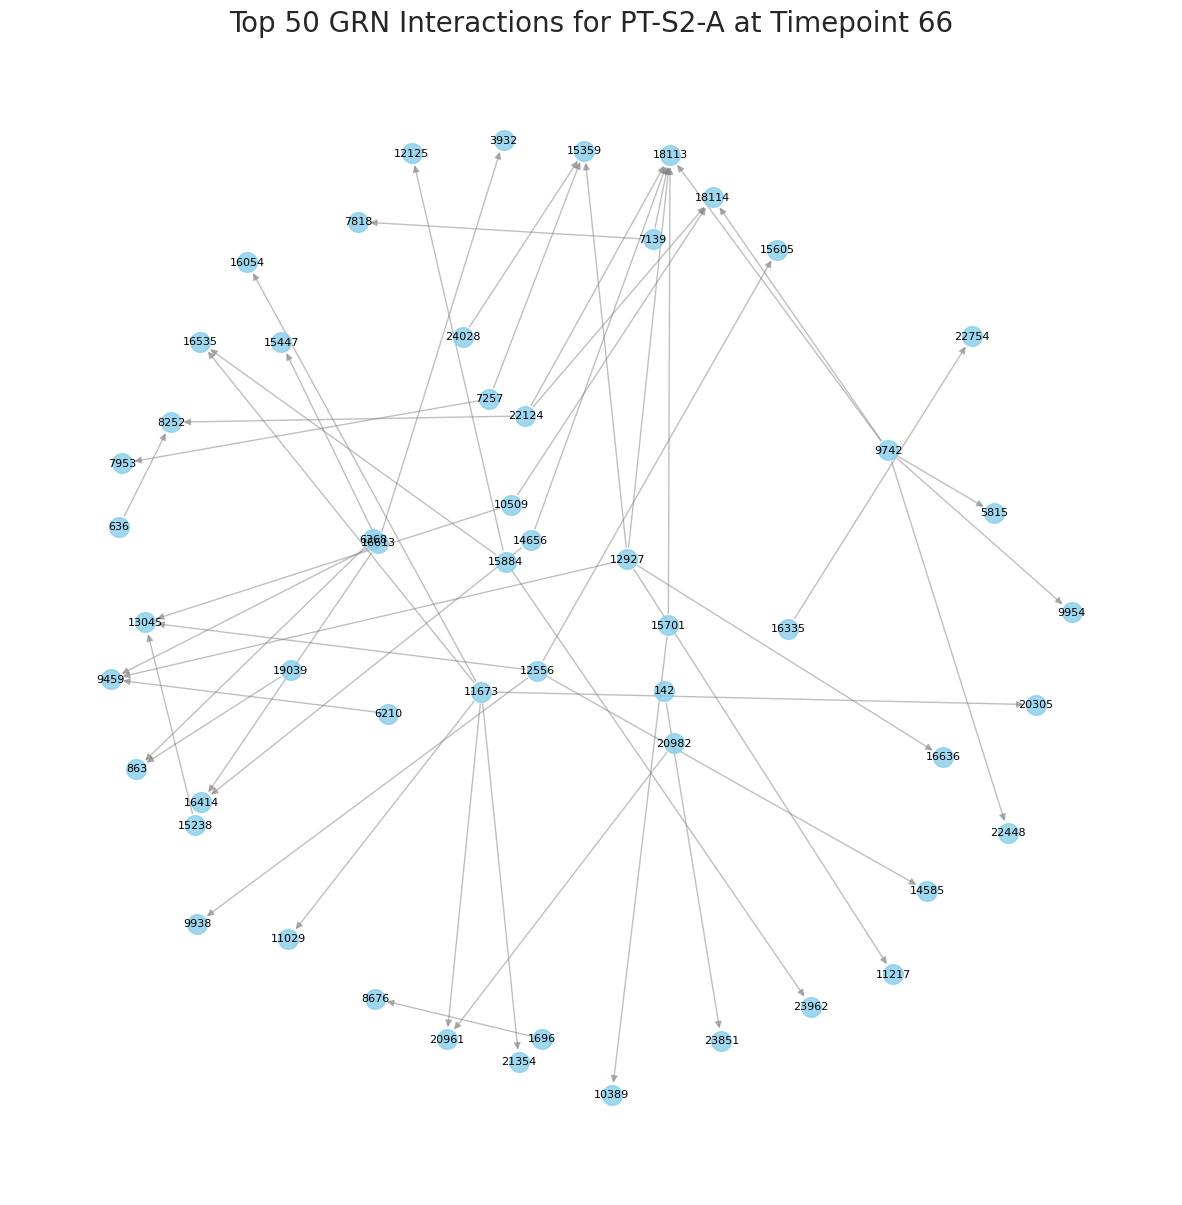


--- Generating plot for: PT-S2-C ---
   ✅ Network visualization has been saved.


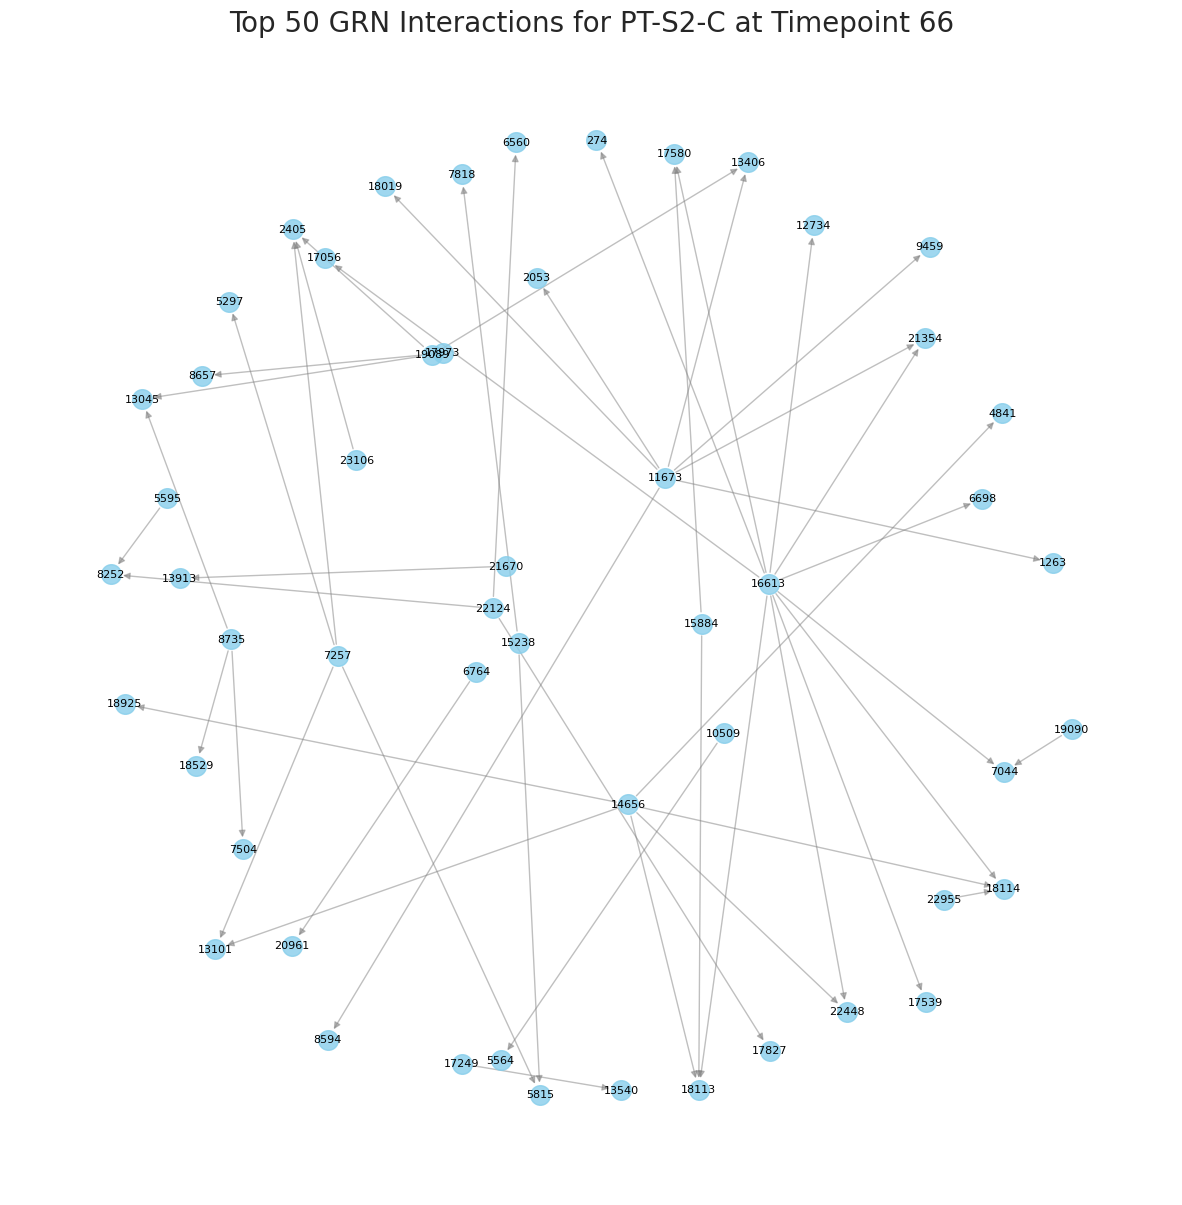


--- Generating plot for: PT-S1-B ---
   ✅ Network visualization has been saved.


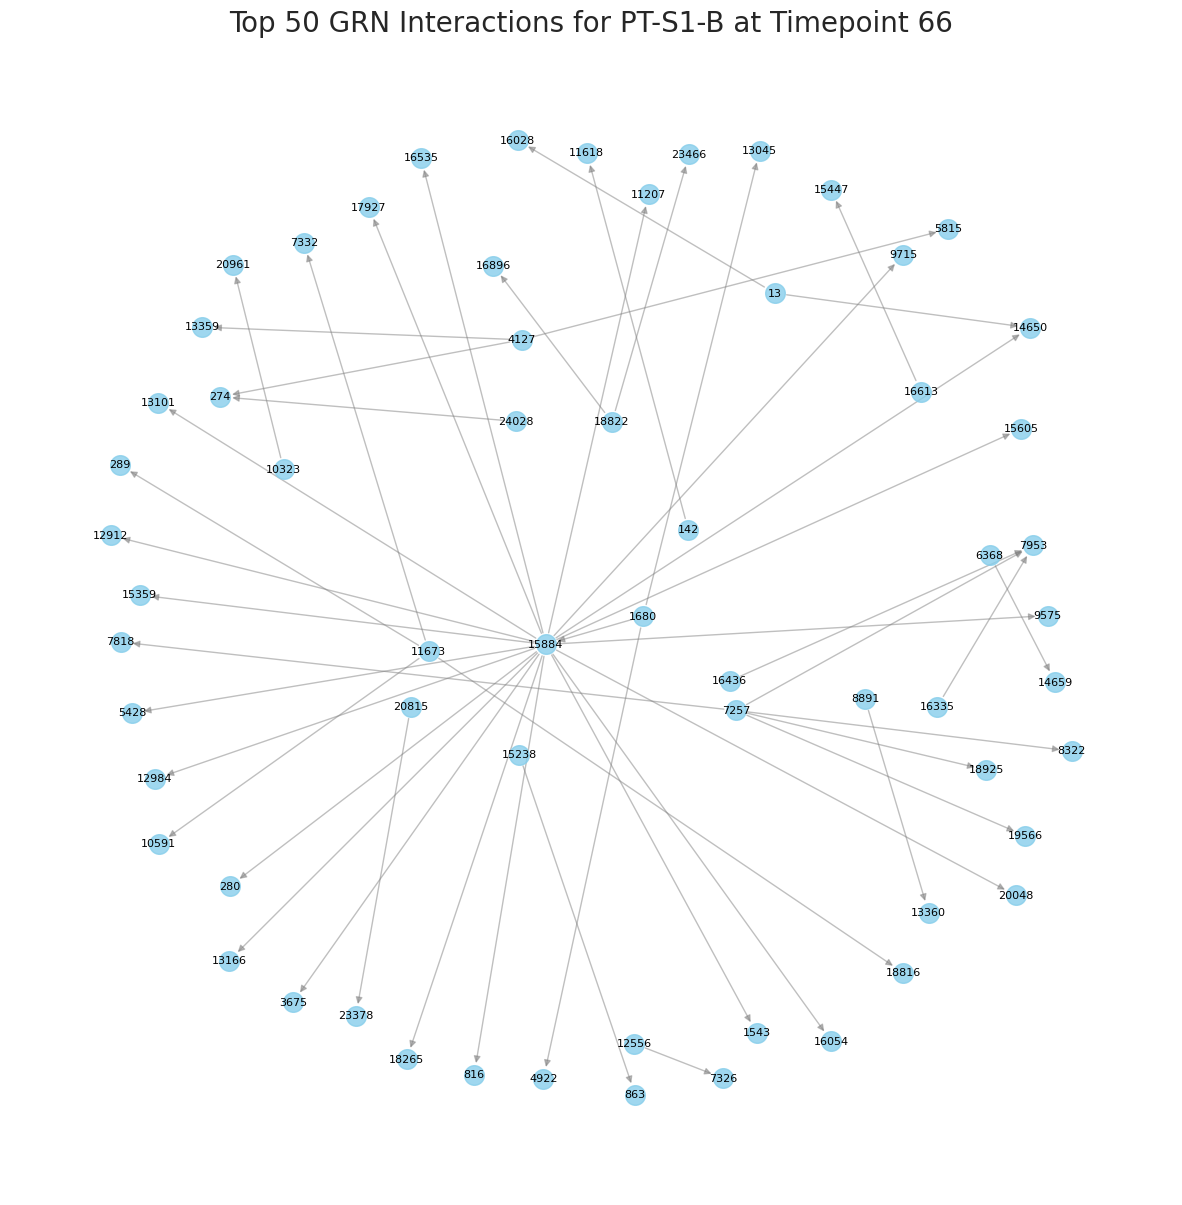


--- Generating plot for: aPT-A ---
   ✅ Network visualization has been saved.


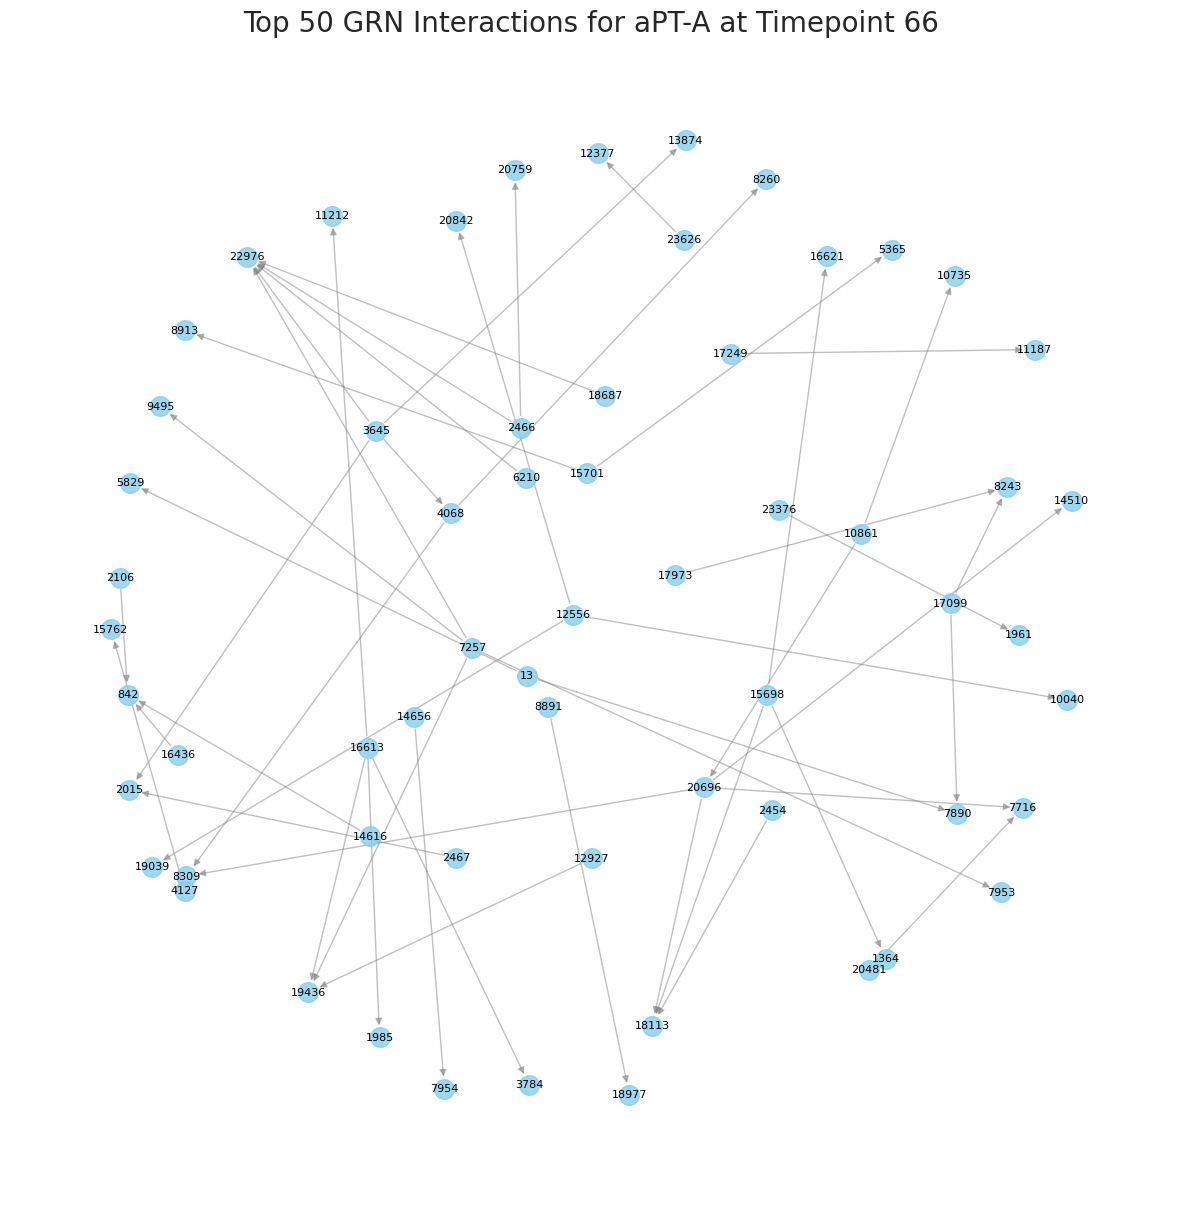


--- Generating plot for: PT-S2-B ---
   ✅ Network visualization has been saved.


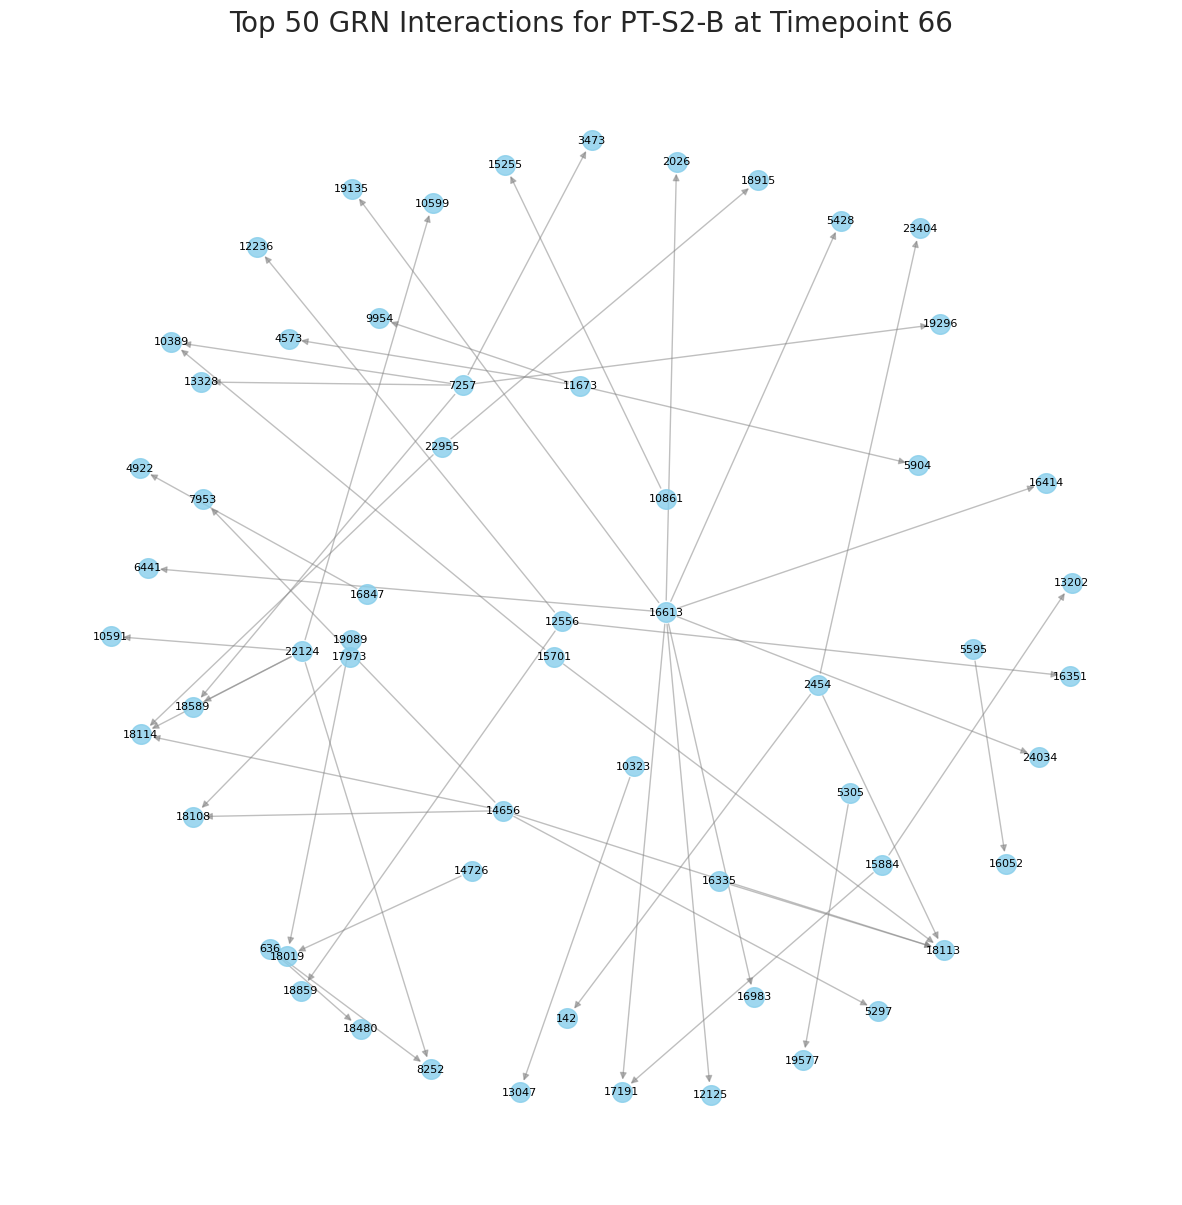


--- Generating plot for: PT-S1-A ---
   ✅ Network visualization has been saved.


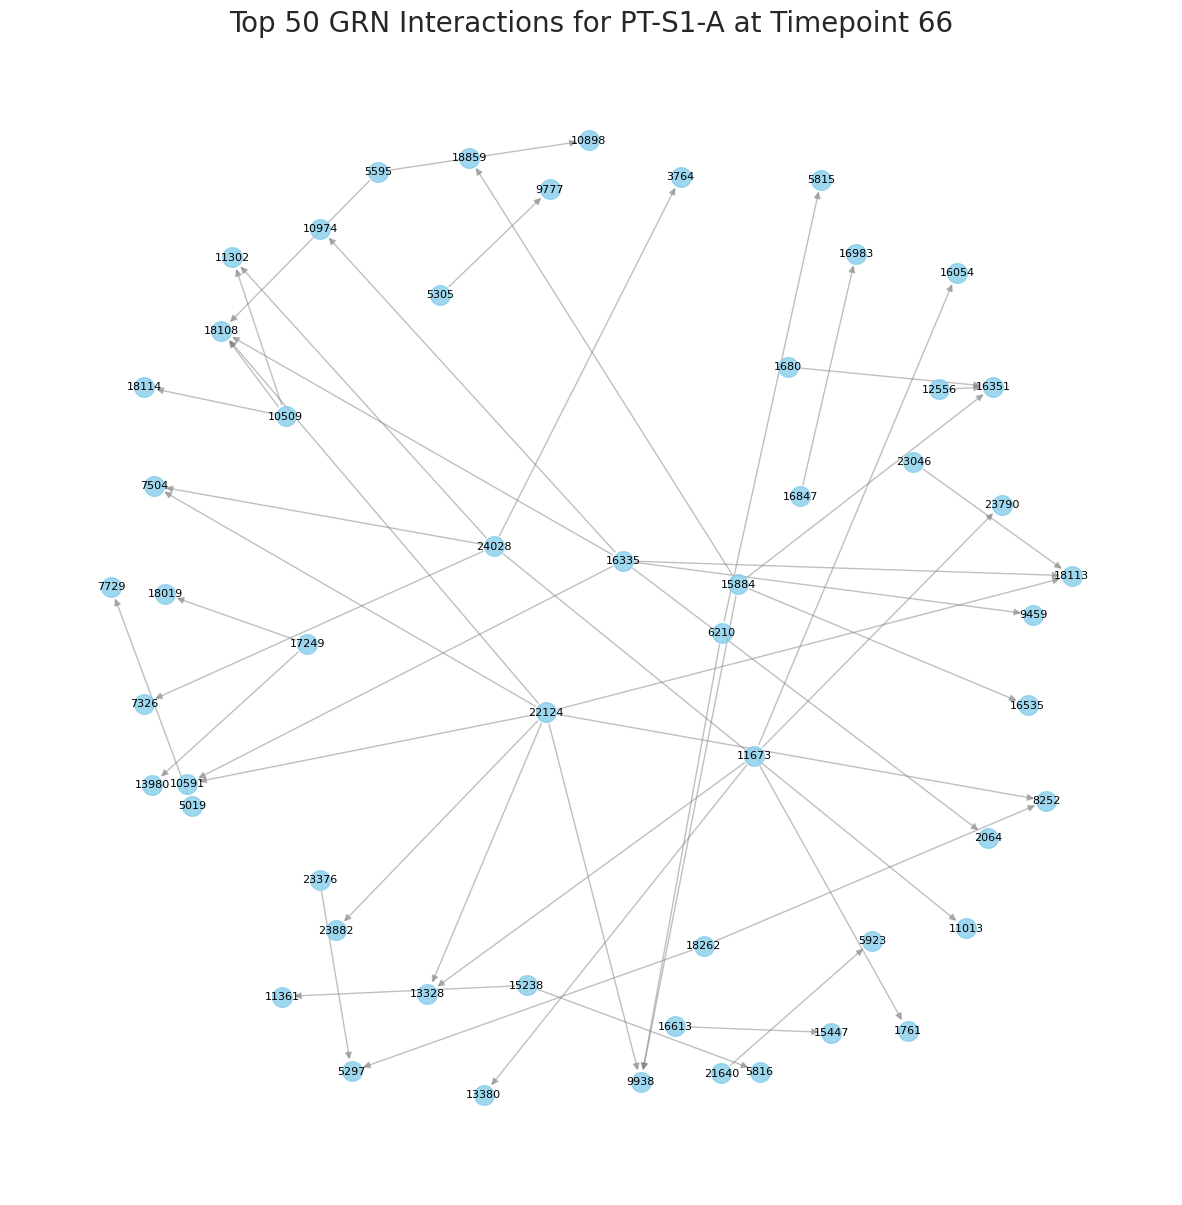


--- Generating plot for: PT-S1-C ---
   ✅ Network visualization has been saved.


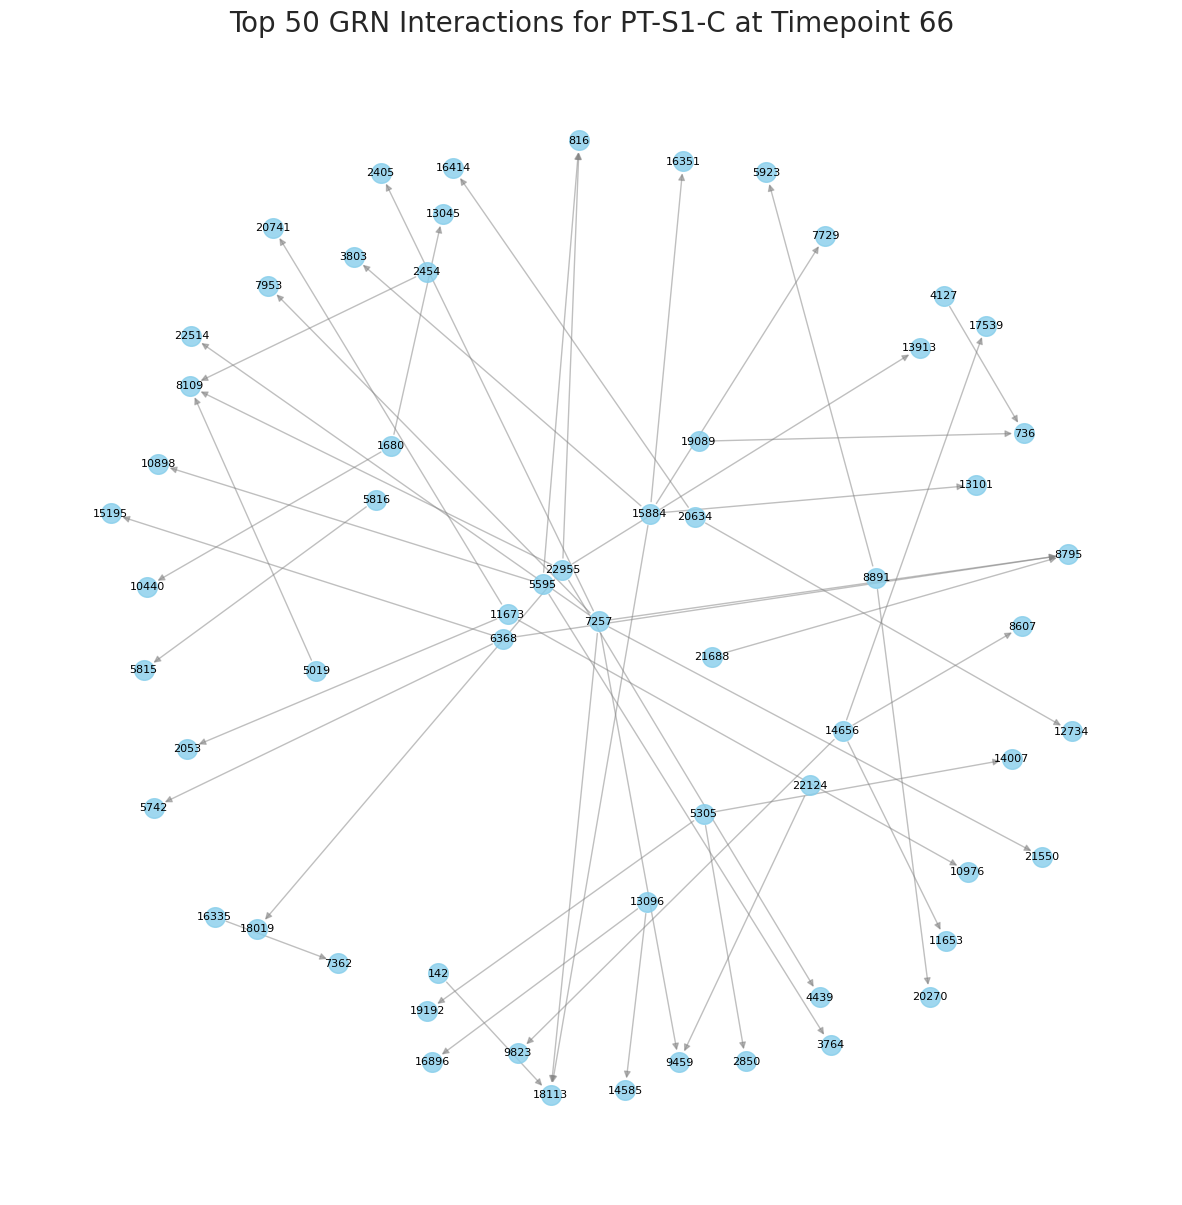


--- Generating plot for: aPT-B ---
   ✅ Network visualization has been saved.


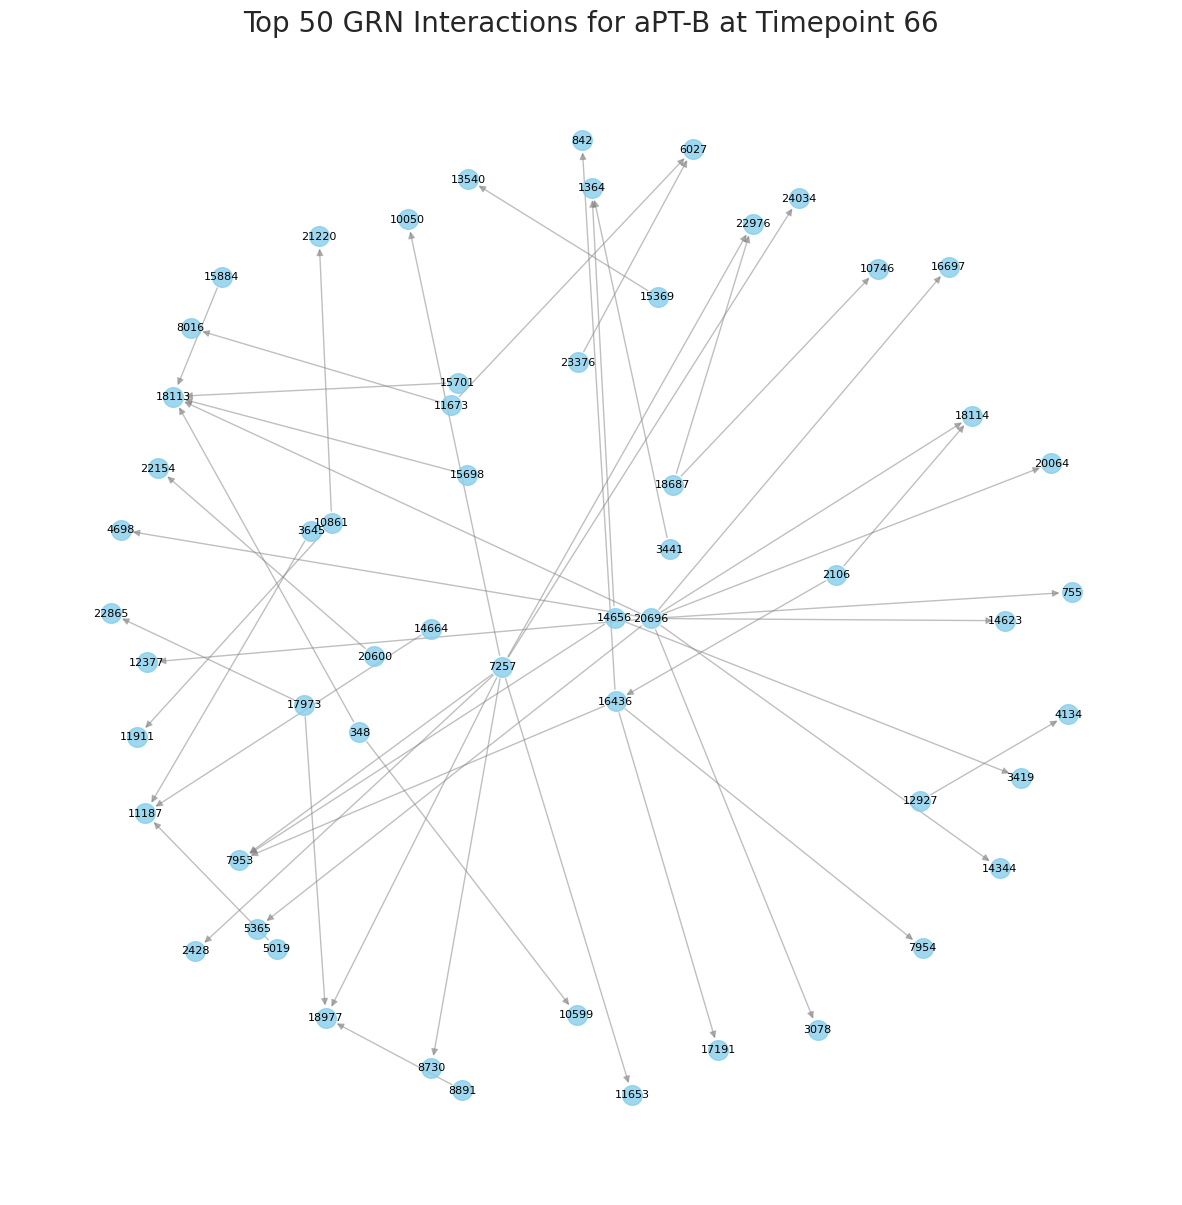


PIPELINE COMPLETED SUCCESSFULLY!


In [8]:
print("--- Starting Section 7 (Multi-Plot Mode): Visualizing All Results ---")

# We will loop through all the 'processed' files to find which cell types we can visualize.
processed_files = [f for f in os.listdir(PROCESSED_GRN_CSV_DIR) if f.startswith("processed_")]

if not processed_files:
    print("⚠️ No processed files found to visualize in the '3_processed_grn_csv' directory.")
else:
    print(f"Found {len(processed_files)} processed cell types to visualize.")

# Loop through each found file and generate a plot
for file_name in processed_files:
    base_name = file_name.replace("processed_", "").replace(".csv", "")
    print(f"\n--- Generating plot for: {base_name} ---")

    # Construct the paths for the two files needed for plotting
    ml_file_path = os.path.join(ML_DATA_DIR, f"ml_{base_name}.csv")
    processed_file_path = os.path.join(PROCESSED_GRN_CSV_DIR, file_name)

    # Check if BOTH required files exist
    if os.path.exists(ml_file_path) and os.path.exists(processed_file_path):

        df = pd.read_csv(ml_file_path)
        processed_df = pd.read_csv(processed_file_path)

        # Ensure there is data to process
        if not df.empty and not processed_df.empty:
            # Find the earliest timepoint FOR THIS DATAFRAME
            earliest_ts = df['ts'].min()
            processed_df_ts = processed_df[processed_df['Timepoints'] == earliest_ts]
            top_interactions = processed_df_ts.nlargest(50, 'coef_abs')

            if top_interactions.empty:
                print(f"   - No significant interactions found to plot for timepoint {earliest_ts}.")
                continue

            # --- The plotting logic is the same, just inside the loop ---
            G = nx.from_pandas_edgelist(top_interactions,
                                        source='source',
                                        target='target',
                                        create_using=nx.DiGraph())

            plt.figure(figsize=(15, 15)) # Create a new figure for each plot
            pos = nx.spring_layout(G, k=0.5, iterations=50)
            nx.draw_networkx_nodes(G, pos, node_size=200, node_color='skyblue', alpha=0.8)
            nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, edge_color='gray', arrows=True)
            nx.draw_networkx_labels(G, pos, font_size=8)

            plt.title(f"Top 50 GRN Interactions for {base_name} at Timepoint {earliest_ts}", fontsize=20)
            plt.axis('off')

            # Save the figure to the '5_figures' directory
            output_figure_file = os.path.join(FIGURE_SAVE_PATH, f"GRN_Visualization_{base_name}_T{earliest_ts}.png")
            plt.savefig(output_figure_file, dpi=300, bbox_inches='tight')

            print(f"   ✅ Network visualization has been saved.")
            plt.show() # This will display the plot for the current cell type in the output
            plt.close() # Close the figure to free up memory before the next loop iteration

        else:
            print(f"   - Skipping plot for {base_name} because one of its data files is empty.")

    else:
        print(f"   - ⚠️ Skipping plot for {base_name} because a required file was not found.")

print("\nPIPELINE COMPLETED SUCCESSFULLY!")